# 1. Setup

## 1.1 Acknowledgements

Code from DATS 6202 case studies was used. Additionally, code and ideas from the following sources were also used:

-A paper on EfficientNetV2B2  
https://www.medrxiv.org/content/10.1101/2022.07.18.22277779v1.full.pdf

-TenserFlow documentation on EfficentNetV2B2  
https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B2

-TensorFlow tutorial on transfer learning  
https://www.tensorflow.org/tutorials/images/transfer_learning

## 1.2 Imports and Settings

In [3]:
import numpy as np
random_state = 123
np.random.seed(random_state)
from matplotlib import pyplot as plt
import seaborn as sns
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from os.path import abspath, join
from os import listdir
import tensorflow as tf
tf.random.set_seed(random_state)
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

from PIL import Image, ImageOps

import warnings
# Ignore warnings
#warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
# tf.compat.v1.logging.ERROR

# import os
# import Augmentor


## 1.3 Getting the image directories

In [4]:
base_dir = 'data/archive/data'
pos_dir = join(base_dir, 'yes')
neg_dir = join(base_dir, 'no')

We observe 3000 original images in the data set.

In [5]:
pos_imgs = listdir(pos_dir)
neg_imgs = listdir(neg_dir)

n_pos = len(pos_imgs)
n_neg = len(neg_imgs)
total_images = n_pos + n_neg
print(f"Total images in the dataset: {total_images}")

Total images in the dataset: 3000


## 1.4 A function for graphing training results

In [6]:
def plot_performance(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    epochs = len(history['loss'])
    axes[0].plot(range(1, epochs+1), history['loss'], '-b', label='Training Loss')
    axes[0].plot(range(1, epochs+1), history['val_loss'], '-r', label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('BCE')
    axes[0].set_title(f'Loss of {model_name}')
    
    axes[1].plot(range(1, epochs+1), history['accuracy'], '-b', label='Training accuracy'),
    axes[1].plot(range(1, epochs+1), history['val_accuracy'], '-r', label='Validation accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title(f'Accuracy of {model_name}')
    plt.tight_layout()
    plt.show()

# 2. Examining the Data Set

## 2.1 Glimpse of the data

We observe top-down, 2-D, grayscale images of the brain. Here, the first two rows of images are those with tumors and the final two rows are those brain images without tumors.

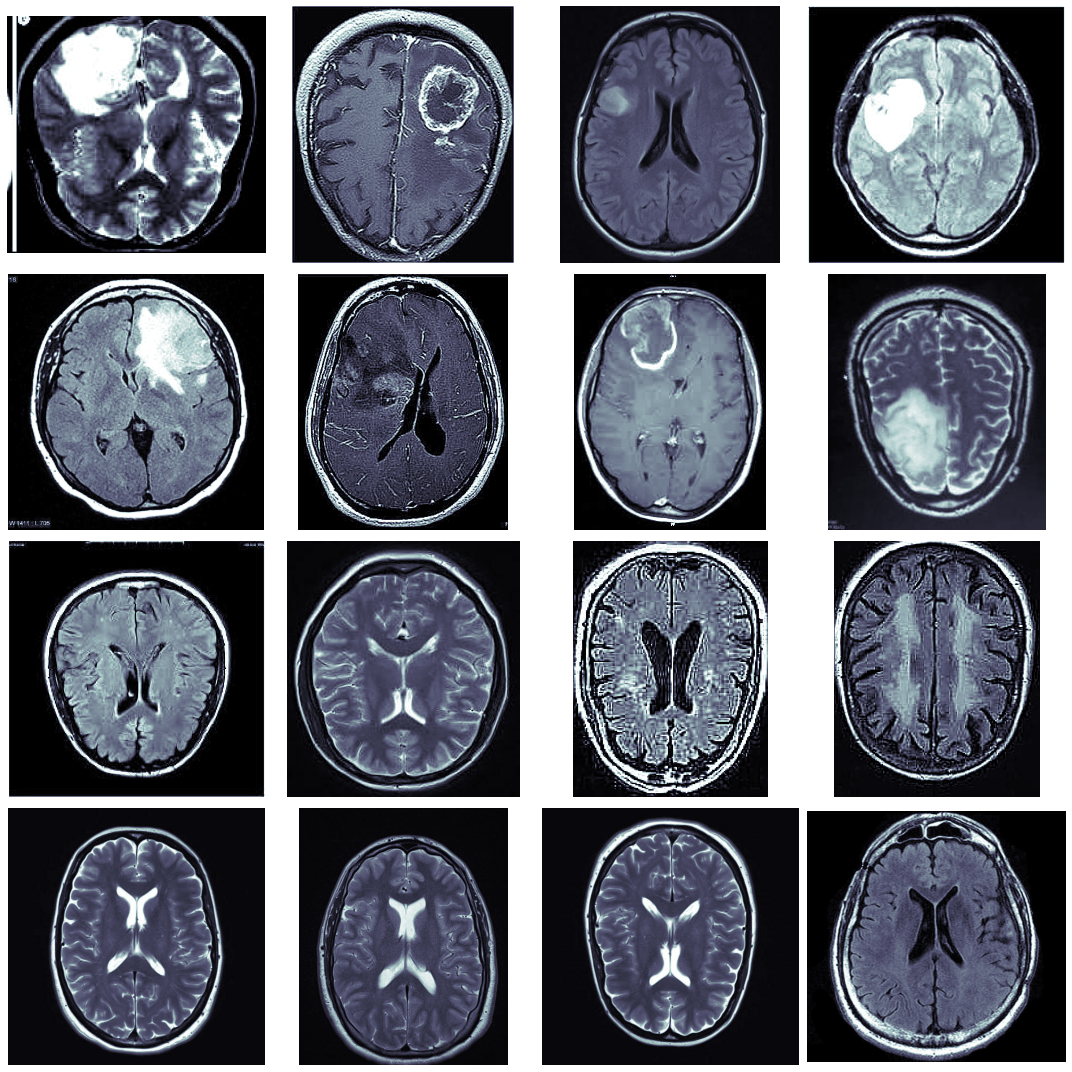

In [7]:
c_idx = 0
r_idx = 0
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for i in range(16):
    file_name = None
    if i < 8:
        # Then load positive image
        file_name = join(pos_dir, pos_imgs[np.random.randint(0, n_pos)])
    else:
        file_name = join(neg_dir, neg_imgs[np.random.randint(0, n_neg)])
    
    tmp_img = ImageOps.grayscale(Image.open(file_name, mode='r'))
    axes[r_idx, c_idx].imshow(tmp_img, cmap="bone")
    axes[r_idx, c_idx].axis("off")
    
    if c_idx == 3:
        c_idx = 0
        r_idx += 1
    else:
        c_idx += 1
fig.tight_layout()
plt.show()

## 2.2 Are all the images of same shape?

### 2.2.1 Comparing image sizes

Our example image is 428 x 417 pixels in size.

In [8]:
tmp_img.size

(428, 417)

Looping over the other images in the data set, we find that they are not all the same size.

In [9]:
pos_fname = join(pos_dir, pos_imgs[0])
prev_size = Image.open(pos_fname, mode='r').size

for i in range(1, len(pos_imgs)):
    pos_fname = join(pos_dir, pos_imgs[i])
    new_size = Image.open(pos_fname, mode='r').size
    if new_size != prev_size:
        print(f"The previous size was: {prev_size} while the new size is: {new_size}")
        break

The previous size was: (287, 348) while the new size is: (587, 630)


So, not all images are of same size. This needs to be addressed while creating the Pipeline. Perhaps we could use resize function in Pillow to ensure all images are resized to a common size. However, one caveat to the approach is, this approach would be fine for downscaling, and in case of upscaling, I might need to rethink about this. Although there are methods such as KNN, or other clustering techniques that can adapted to perform interpolation while resizing, there are better ways to handle this.

### 2.2.2 Find the minimal size from the set of all images

In [10]:
pos_fname = join(pos_dir, pos_imgs[0])
min_size = Image.open(pos_fname, mode='r').size

for i in range(1, len(pos_imgs)):
    pos_fname = join(pos_dir, pos_imgs[i])
    new_size = Image.open(pos_fname, mode='r').size
    if new_size < min_size:
        min_size = new_size

for i in range(len(neg_imgs)):
    neg_fname = join(neg_dir, neg_imgs[i])
    new_size = Image.open(neg_fname, mode='r').size
    if new_size < min_size:
        min_size = new_size

print(f"Minimum size from the set of all images: {min_size}")

Minimum size from the set of all images: (150, 198)


## 2.3 Resizing images

We can use the `resize` function to make sure all images are all of the same size. Our example image is resized below. When creating the TensorFlow data sets, we will be able to do this resizing with built-in functions.

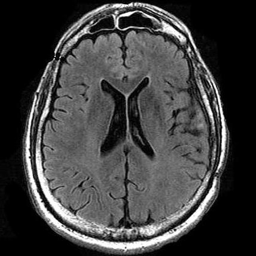

In [11]:
tmp_img.resize([256, 256])

# 3. Preparing the Data

## 3.1 Load and shuffle the images

We use a Keras API function to load in image data, assigning labels of `yes` (tumor present) and `no` (tumor absent) to each image as we do so. We build training, validation, and test data sets. This function also resizes the images as it builds the data sets. The training set has 2400 original images and the validation and test sets each have 300 images.

In [12]:
## Pipeline
#batch_size = 32
#img_size = [224, 224]

shuffle=True
batch_size = 30
img_size = [256, 256]


base_dir = 'data/archive/sets'

# Create the training set
train_dir = join(base_dir, 'train')
train_ds = keras.utils.image_dataset_from_directory(train_dir,
                                                    label_mode='binary', class_names = ['yes', 'no'],
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    image_size=img_size,
                                                    shuffle=shuffle,
                                                    seed=random_state,
                                                    validation_split=None,
                                                    interpolation='bilinear')


# Create the validation set
val_dir = join(base_dir, 'validation')
val_ds = keras.utils.image_dataset_from_directory(val_dir,
                                                  label_mode='binary', class_names = ['yes', 'no'],
                                                  color_mode='grayscale',
                                                  batch_size=batch_size,
                                                  image_size=img_size,
                                                  shuffle=shuffle,
                                                  seed=random_state,
                                                  validation_split=None,
                                                  interpolation='bilinear')

# Create the test set
test_dir = join(base_dir, 'test')
test_ds = keras.utils.image_dataset_from_directory(test_dir,
                                                   label_mode='binary', class_names = ['yes', 'no'],
                                                   color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   image_size=img_size,
                                                   shuffle=shuffle,
                                                   seed=random_state,
                                                   validation_split=None,
                                                   interpolation='bilinear')



Found 1800 files belonging to 2 classes.
Found 600 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


In [13]:
train_files = set(listdir(join(train_dir, 'yes')))
val_files = set(listdir(join(val_dir, 'yes')))
test_files = set(listdir(join(test_dir, 'yes')))

In [14]:
train_files.intersection(val_files)

set()

In [15]:
train_files.intersection(test_files)

set()

## 3.2 Data Augmentation

We have 2400 original training images. These are all evenly split between tumor and non-tumor images. We decided to use data augmentation to increase the size of our data set as well as provide different looks to the model to help it better identify the images correctly. We can create an augmentation pipeline to be applied at the beginning of the model.

We create an augmentation pipeline, passing the different types of augmentation we want to perform. We will do some random flipping, and changing of the brightness and contrast. We also added in a small amount of random noise to the pixel data. We only augment the training data, so that our validation and testing is being done only with original images.

In [16]:
data_augmentation = tf.keras.Sequential([
  RandomFlip(mode='horizontal', seed=random_state),
  #RandomRotation(factor=[-0.5, 0.5], fill_mode='constant', fill_value=0, interpolation='bilinear'),
  RandomBrightness(factor=[0, 0.3], value_range=[0, 1.], seed=random_state),
  RandomContrast(factor=[0, 0.3], seed=random_state),
  GaussianNoise(stddev=tf.math.sqrt(0.05), seed=random_state)
])

In [17]:
# new_train = new_train.map(lambda x, y: (data_augmentation(x, training=True), y), 
#                 num_parallel_calls=tf.data.experimental.AUTOTUNE)

## 3.3 Prefetch for training

We prefetch the data so that the model will alwys have data ready to go each round of training. This improves the efficency of the training process by reducing the latency in initiating training subsequent steps in an epoch.

In [18]:
buffer_size=2

# prefetch the training data
new_train = train_ds.prefetch(buffer_size)

# prefetch the validation data
new_val = val_ds.prefetch(buffer_size)

# prefetch the test data
new_test = test_ds.prefetch(buffer_size)

We observe that the training data set is a prefetchDataset TensorFlow object.

In [19]:
new_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

# 4. Building our Own Model

We want to see how building our own model compares against using a pre-trained model.

## 4.1 Model Architecture

TEXT HERE

In [129]:
model_own = Sequential([
                InputLayer(input_shape=[256, 256, 1], batch_size=batch_size),
                Rescaling(1./255),
                data_augmentation,
                BatchNormalization(),
                Conv2D(filters=32, kernel_size=5, activation='relu'), # 252x252
                MaxPool2D(), # 126x126
                BatchNormalization(),
                Conv2D(filters=64, kernel_size=3, activation='relu'), # 124x124
                MaxPool2D(), # 62x62
                BatchNormalization(),
                Conv2D(filters=128, kernel_size=3, activation='relu'), # 60x60
                MaxPool2D(), # 30x30
                BatchNormalization(),
                Flatten(),
                Dense(128, activation='relu'),
                BatchNormalization(),
                Dense(10, activation='relu'),
                BatchNormalization(),
                Dense(1, activation='sigmoid')
            ])

In [130]:
model_own.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (30, 256, 256, 1)         0         
                                                                 
 sequential_11 (Sequential)  (None, 256, 256, 1)       0         
                                                                 
 batch_normalization_93 (Bat  (None, 256, 256, 1)      4         
 chNormalization)                                                
                                                                 
 conv2d_70 (Conv2D)          (None, 252, 252, 32)      832       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 126, 126, 32)     0         
 g2D)                                                            
                                                                 
 batch_normalization_94 (Bat  (None, 126, 126, 32)   

## 4.2 Setting our own model callbacks

We identify the directory to store our model checkpoints, only saving a model and its weights if they are the best we have seen so far. We also setup Power Scheduling to adjust our learning rate to deal with the vanishing/eploding gradient problem. An Early Stopping callback protects against overfitting.

In [131]:
# Where to store the best model and its weights
model_path='data/archive/results/model_own/'

# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=model_path + '/model.own',
                                                      save_best_only=True,
                                                      save_weights_only=True)
# ReduceLROnPlateau callback
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_accuracy',
                factor=0.1,
                patience=10,
                verbose=1,
                mode='max',
                min_delta=0.0001,
                min_lr=1e-7
             )

# NaN callback
terminate_nan_cb = tf.keras.callbacks.TerminateOnNaN()

# Early Stopping Callback
es_cb = tf.keras.callbacks.EarlyStopping(
                        monitor='val_accuracy',
                        min_delta=1e-4,
                        patience=10,
                        verbose=1,
                        mode='max',
                        restore_best_weights=True,
                        start_from_epoch=0
                    )

## 4.3 Custom functions for evaluation

This custom function that calculates macro F1 will be used for evaluation purposes in addition to accuracy.

In [37]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
        r_pos = true_positives / (possible_positives + K.epsilon())
        r_neg = true_negatives / (possible_negatives + K.epsilon())
        return 0.5 * (r_pos + r_neg)

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        true_negatives = K.sum(K.round(K.clip(1-y_true * 1-y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        predicted_negatives = K.sum(K.round(K.clip(1-y_pred, 0, 1)))
        p_pos = true_positives / (predicted_positives + K.epsilon())
        p_neg = true_negatives / (predicted_negatives + K.epsilon())
        return 0.5 * (p_pos + p_neg)
    
    p_macro = precision(y_true, y_pred)
    r_macro = recall(y_true, y_pred)
    return 2*((p_macro*r_macro)/(p_macro+r_macro+K.epsilon()))

## 4.4 Compiling our own model

In [133]:
model_own.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1])

## 4.5 Training our own Model

We will train our own model through 20 epochs. We observe that the model quite quickly reaches a very high accuracy with the validation data.

In [135]:
history_own = model_own.fit(new_train,
                            batch_size=batch_size,
                            epochs=20,
                            verbose=1,
                            validation_data=new_val,
                            workers=16,
                            use_multiprocessing=True,
                            callbacks=[lr_schedule,
                                       terminate_nan_cb,
                                       es_cb,
                                       model_checkpoint_cb]
                    )

Epoch 1/20
80/80 [==============================] - 104s 1s/step - loss: 0.4462 - accuracy: 0.7892 - f1: 0.7942 - val_loss: 0.7204 - val_accuracy: 0.5000 - val_f1: 0.3322 - lr: 0.0010
Epoch 2/20
80/80 [==============================] - 101s 1s/step - loss: 0.2079 - accuracy: 0.9262 - f1: 0.9287 - val_loss: 0.6768 - val_accuracy: 0.5833 - val_f1: 0.6276 - lr: 0.0010
Epoch 3/20
80/80 [==============================] - 96s 1s/step - loss: 0.0852 - accuracy: 0.9771 - f1: 0.9775 - val_loss: 0.1621 - val_accuracy: 0.9700 - val_f1: 0.9709 - lr: 0.0010
Epoch 4/20
80/80 [==============================] - 96s 1s/step - loss: 0.0578 - accuracy: 0.9846 - f1: 0.9846 - val_loss: 0.1786 - val_accuracy: 0.9233 - val_f1: 0.9263 - lr: 0.0010
Epoch 5/20
80/80 [==============================] - 97s 1s/step - loss: 0.0470 - accuracy: 0.9862 - f1: 0.9859 - val_loss: 0.0632 - val_accuracy: 0.9833 - val_f1: 0.9838 - lr: 0.0010
Epoch 6/20
80/80 [==============================] - 99s 1s/step - loss: 0.0260 - ac

## 4.6 Evaluating our own Model

Since we used a model checkpoint to store the best verion of the model trained so far, we are able to reload the best version's weights. We observe that the model has an accuracy of 0.93 and a macro F1 of 0.9344 on the test data.

In [136]:
model_own.load_weights(filepath= model_path + '/model.own')
loss, accuracy, f1_score = model_own.evaluate(new_test)

10/10 [==============================] - 2s 214ms/step - loss: 0.4836 - accuracy: 0.9300 - f1: 0.9344


## 4.7 Plotting performance of our model

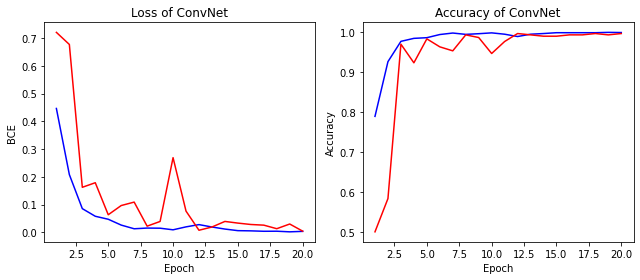

In [212]:
plot_performance(history_own.history, 'ConvNet')

# 5. Using the pretrained model, EfficentNetV2B2

## 5.1 loading the pretrained model

EfficentNetV2B2 can take images of any size and with three input channels. EfficientNetV2B2 includes a pre-processing step at the start of the model, so we don't need to explicitly run a function or add a layer to do this. It will be able to take our grayscale images with one input channel and convert it to the format the model is expecting. 

We don't include the top layers of the model, as we want to tailor the predictions to our data. Instead, we will add our own top layers.  Additionally, this model has the option to include a pooling layer before we add our own layers, so we also do not need to explicitly add a pooling layer. Here, we choose a global average pooling layer.

In [144]:
# setting the color channel to grayscale
img_shape = img_size + [3,]

# instantiating the model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B2(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='avg',
    include_preprocessing=True
)

## 5.2 Freezing the pre-trained layers

We observe that the pre-trained model has no trainable parameters, as all its layers are frozen.

In [145]:
# freeze all pre-trained layers
base_model.trainable = False

# observe the layers and trainable parameters
base_model.summary()

Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_11 (Rescaling)       (None, 256, 256, 3)  0           ['input_13[0][0]']               
                                                                                                  
 normalization_2 (Normalization  (None, 256, 256, 3)  0          ['rescaling_11[0][0]']           
 )                                                                                                
                                                                                  

## 5.3 Building the training pipeline

### 5.3.1 Preparing new layer types

In [146]:
# add a resize layer so that there are RGB channels (3) instead of just grayscale (1)
# we would need this if uing Resnet but not for EfficentNetV2B2
#resize = Conv2D(3,(3,3), padding='same')

# add the pre-processing layer
# we would need this if uing Resnet but its included for for EfficentNetV2B2
#preprocess_input = tf.keras.applications.resnet.preprocess_input


# add a global average pooling layer
# we would need this if uing Resnet but its included for for EfficentNetV2B2
#global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# add a flattening layer
flatten = Flatten()

# add a dense layer
dense1 = Dense(128, activation='relu')
dense2 = Dense(10, activation='relu'),

# add Dropout layer
dropout2 = keras.layers.Dropout(0.2)
dropout4 = keras.layers.Dropout(0.4)

# add an output layer
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

### 5.3.2 Add layers on top of pre-trained model

Here we will add a flattening layer, as well as a dense layer, and a dropout layer. These layers help tune the predictions to fit our data. Finally, we add an output layer using the sigmoid activation so that we can do binary classification.

In [147]:
inputs = tf.keras.Input(shape=(256, 256, 1))
x = base_model(inputs, training=False)
x = flatten(x)
x = dense1(x) 
x = dropout4(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## 5.4 Compile the full model

We compile the model with the Adam optomizer, setting a starting learning rate of 0.001 which is good practice. Since we are dealing with only two classes, we set the loss to binary crossentropy. Finally, we use the accuracy metric, as well as the macro F1 metric to evaluate how the training process. WE observe that we now have over 180K parameters to train. These parameters all come from our added layers, as the pre-trained layers are still frozen.

In [148]:
# set the starting learning rate
base_learning_rate = 0.001

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy', f1])

# view the full model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 efficientnetv2-b2 (Function  (None, 1408)             8769374   
 al)                                                             
                                                                 
 flatten_11 (Flatten)        (None, 1408)              0         
                                                                 
 dense_32 (Dense)            (None, 128)               180352    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 1)                 129       
                                                           

## 5.5 Modify model callbacks

We modify the callbacks to be more sensitive to lack of model improvement as we train our added layers. Our Earl Stopping patientce parameters is reduced from 10 to 5. Our Power Scheduling patience parameter is reduced to 3.

In [149]:
model_path='data/archive/results/model_pretrained/'

# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=model_path + '/model.pretrained',
                                                      save_best_only=True,
                                                      save_weights_only=True)

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  min_delta=1e-4,
                                                  patience=5,
                                                  verbose=1,
                                                  mode='max',
                                                  restore_best_weights=True,
                                                  start_from_epoch=0)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                            min_delta=1e-4,
                                                            min_lr=1e-7,
                                                            patience=3,
                                                            factor=0.1,
                                                            verbose=1,
                                                            mode='max')

## 5.6 Train the added layers

With the pre-trained layers frozen, we run the model to train the added layers for 20 epochs and make predictions on our data specifically. We observe that, quite quickly, the model achieve a high accuracy and macro F1.

In [150]:
initial_epochs = 20

history_eff = model.fit(new_train,
                    batch_size=batch_size,
                    epochs=initial_epochs,
                    verbose=1,
                    validation_data=new_val,
                    workers=16,
                    use_multiprocessing=True,
                    callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/20
80/80 [==============================] - 88s 1s/step - loss: 0.2740 - accuracy: 0.8808 - f1: 0.8806 - val_loss: 0.1500 - val_accuracy: 0.9400 - val_f1: 0.9409 - lr: 0.0010
Epoch 2/20
80/80 [==============================] - 81s 1s/step - loss: 0.1262 - accuracy: 0.9496 - f1: 0.9502 - val_loss: 0.1008 - val_accuracy: 0.9633 - val_f1: 0.9642 - lr: 0.0010
Epoch 3/20
80/80 [==============================] - 81s 1s/step - loss: 0.0851 - accuracy: 0.9708 - f1: 0.9709 - val_loss: 0.0614 - val_accuracy: 0.9733 - val_f1: 0.9740 - lr: 0.0010
Epoch 4/20
80/80 [==============================] - 81s 1s/step - loss: 0.0602 - accuracy: 0.9842 - f1: 0.9844 - val_loss: 0.0424 - val_accuracy: 0.9867 - val_f1: 0.9871 - lr: 0.0010
Epoch 5/20
80/80 [==============================] - 81s 1s/step - loss: 0.0538 - accuracy: 0.9837 - f1: 0.9840 - val_loss: 0.0398 - val_accuracy: 0.9933 - val_f1: 0.9933 - lr: 0.0010
Epoch 6/20
80/80 [==============================] - 80s 1s/step - loss: 0.0348 - accu

## 5.7 Unfreeze the pre-trained layers

### 5.7.1 Determine the number of layers and select which to unfreeze

Now that our top layers our trained to predict for our data specifically, we want to fine tune the model. We unfreeze some number of the pre-trained model's layers. In this case, we unfreeze the top 75 layers of the 350 layers that the pre-trained model has. We will retrain the model with the weights of these top layers now being modifiable.

In [151]:
# number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 275

# Freeze all the layers before the `fine_tune_at` layer
base_model.trainable = True

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

print("Number of layers that will be unfrozen for training: ", len(base_model.layers)-fine_tune_at)

Number of layers in the base model:  350
Number of layers that will be unfrozen for training:  75


### 5.7.2 Re-compile the unfrozen model

Whenever we make some changes to the model, we need to recompile the model for those changes to take effect. As we do so, we also reduce the learning rate of the optomizer by a factor of 10. We do this so that as the model trains the newly unfrozen layers, we don't loose all the work we did training the added layers from the previous step.

In [154]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss='binary_crossentropy',
              metrics=['accuracy', f1])

# view the full model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 efficientnetv2-b2 (Function  (None, 1408)             8769374   
 al)                                                             
                                                                 
 flatten_11 (Flatten)        (None, 1408)              0         
                                                                 
 dense_32 (Dense)            (None, 128)               180352    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 1)                 129       
                                                           

## 5.8 Train the unfrozen model

We add 20 epochs for fine tuning. We also create a new history variable, so that we can track the progress of the model through all the different training steps. We observe that the model achieves over 0.99 accuracy and macro F1 in the validation data.

In [157]:
# Additional number of epochs
fine_tune_epochs = 20
total_epochs =  history_eff.epoch[-1]+1 + fine_tune_epochs

# run the training, starting at the next epoch
history_fine_tune = model.fit(new_train,
                    batch_size=batch_size,
                    epochs=total_epochs,
                    initial_epoch=history_eff.epoch[-1]+1,
                    verbose=1,
                    validation_data=new_val,
                    workers=16,
                    use_multiprocessing=True,
                    callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 12/31
80/80 [==============================] - 108s 1s/step - loss: 0.0451 - accuracy: 0.9808 - f1: 0.9814 - val_loss: 0.0250 - val_accuracy: 0.9933 - val_f1: 0.9935 - lr: 1.0000e-04
Epoch 13/31
80/80 [==============================] - 107s 1s/step - loss: 0.0094 - accuracy: 0.9979 - f1: 0.9980 - val_loss: 0.0104 - val_accuracy: 1.0000 - val_f1: 1.0000 - lr: 1.0000e-04
Epoch 14/31
80/80 [==============================] - 106s 1s/step - loss: 0.0051 - accuracy: 0.9987 - f1: 0.9988 - val_loss: 0.0241 - val_accuracy: 0.9933 - val_f1: 0.9934 - lr: 1.0000e-04
Epoch 15/31
80/80 [==============================] - 106s 1s/step - loss: 0.0151 - accuracy: 0.9937 - f1: 0.9939 - val_loss: 0.0971 - val_accuracy: 0.9767 - val_f1: 0.9768 - lr: 1.0000e-04
Epoch 16/31
80/80 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9979 - f1: 0.9979
Epoch 16: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
80/80 [==============================] - 106s 1s/step - los

## 5.9 Evaluate the unfrozen model

We reload the wieghts from the best version of the model.

In [158]:
model.load_weights(filepath= model_path + '/model.pretrained')

Using the best version of the model, we test it on the test data. The accuracy of the model on the test data is 0.9233. The macro F1 score for the model on the test data is 0.9235.

In [159]:
loss, accuracy, f1_score = model.evaluate(new_test)

10/10 [==============================] - 9s 865ms/step - loss: 0.3415 - accuracy: 0.9233 - f1: 0.9235


## 5.10 Plot training performance of pretrained model

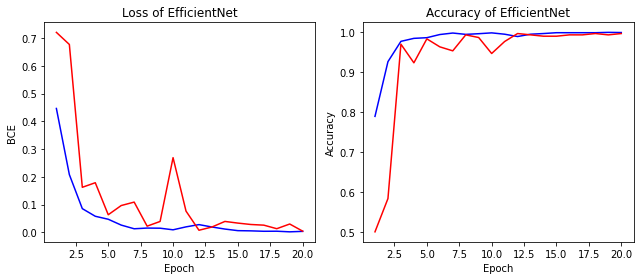

In [214]:
plot_performance(history_own.history, 'EfficientNet')

# 6. Residual Network

In [20]:
def conv(x, filters, kernel_size=3, activation='selu', downsample=False):
    padding = 'same'
    if downsample:
        padding = 'valid'
    x = BatchNormalization()(x)
    return Conv2D(filters=filters, kernel_size=kernel_size, \
                  padding=padding, activation=activation)(x)

In [21]:
def res_block(x, filters):
    input_depth = x.shape[-1]
    y = LayerNormalization()(x)
    y = BatchNormalization()(y)
    y = Conv2D(filters=input_depth//2, kernel_size=1, activation='selu', padding='same')(y)
    y = LayerNormalization()(y)
    y = BatchNormalization()(y)
    y = Conv2D(filters=input_depth//2, kernel_size=3, activation='selu', padding='same')(y)
    y = LayerNormalization()(y)
    y = BatchNormalization()(y)
    y = Conv2D(filters=input_depth, kernel_size=1, activation='selu', padding='same')(y)
    return Add()([y, x])

In [22]:
def conv_block(x, filters, kernel_size=3):
    y = LayerNormalization()(x)
    y = conv(x=y, kernel_size=kernel_size, filters=filters, downsample=True)
    y = conv(x=y, kernel_size=kernel_size, filters=filters, downsample=True)
    y = AveragePooling2D()(y)
    return y

In [73]:
from tensorflow.keras.layers.experimental import RandomFourierFeatures

In [105]:
x2 = Input(shape=[256, 256, 1], batch_size=None, dtype=tf.float32)

#---------------------------------------------
#-----------PREPROCESSING---------------------
y2 = Rescaling(scale=1./255)(x2)

#-----------DATA AUGMENTATION-----------------
y2 = RandomFlip(mode='horizontal_and_vertical', seed=random_state)(y2)
y2 = RandomBrightness(factor=[0, 0.3], value_range=[0, 1.], seed=random_state)(y2)
y2 = RandomContrast(factor=[0, 0.3], seed=random_state)(y2)
y2 = GaussianNoise(stddev=tf.math.sqrt(0.05), seed=random_state)(y2)
#---------------------------------------------

y2 = conv(y2, filters=32, kernel_size=7, downsample=True) # 250x250x32
y2 = AveragePooling2D()(y2) # 125x125x32

# 1st block - 6 layers
for i in range(3):
    y2 = res_block(y2, filters=32)  # 125x125x32

# 2nd block - 8 layers
y2 = conv_block(y2, filters=64) # 60x60x64
for i in range(3):
    y2 = res_block(y2, filters=64) # 60x60x64

# 3rd block - 12 layers
y2 = conv_block(y2, filters=128) # 28x28x128
for i in range(5):
    y2 = res_block(y2, filters=128) # 28x28x128

# 4th block - 6 layers
y2 = conv_block(y2, filters=256) # 24x24x256
for i in range(2):
    y2 = res_block(y2, filters=256) # 12x12x256
    
# so far 33 layers
y2 = conv_block(y2, filters=128) # 4x4x128 # Now 35 layers
y2 = BatchNormalization()(y2)
y2 = Conv2D(filters=32, kernel_size=4, padding='valid', activation='selu')(y2)
y2 = Flatten()(y2)
y2 = BatchNormalization()(y2)
y2 = Dense(10, activation='selu')(y2)
y2 = BatchNormalization()(y2)
y2 = Dense(1, activation='sigmoid')(y2)

resnet = keras.Model(inputs=[x2], outputs=[y2])
resnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 256, 256, 1)  0           ['input_6[0][0]']                
                                                                                                  
 random_flip_6 (RandomFlip)     (None, 256, 256, 1)  0           ['rescaling_5[0][0]']            
                                                                                                  
 random_brightness_5 (RandomBri  (None, 256, 256, 1)  0          ['random_flip_6[0][0]']    

In [106]:
resnet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
               loss='binary_crossentropy', metrics=['accuracy', f1])

In [107]:
model_path='data/archive/results/model_resnet/'

lr_schedule2 = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.1,
                patience=2,
                verbose=1,
                mode='min',
                min_delta=0.0001,
                min_lr=1e-7
             )

model_checkpoint_cb2 = keras.callbacks.ModelCheckpoint(filepath=model_path,
                                                      monitor='val_loss',
                                                      mode='min',
                                                      save_best_only=True,
                                                      save_weights_only=True)

# Early Stopping Callback
es_cb2 = tf.keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        min_delta=1e-4,
                        patience=10,
                        verbose=1,
                        mode='min',
                        restore_best_weights=True,
                        start_from_epoch=0
                    )

In [108]:
resnet_history = resnet.fit(new_train,
                            batch_size=batch_size,
                            epochs=200,
                            verbose=1,
                            validation_data=new_val,
                            workers=16,
                            use_multiprocessing=True,
                            callbacks=[lr_schedule2,
                                       terminate_nan_cb,
                                       es_cb2,
                                       model_checkpoint_cb2]
                         )

Epoch 1/200


KeyboardInterrupt: 

In [ ]:
resnet.evaluate(new_test)

In [ ]:
plot_performance(resnet_history.history, 'ResidualNet')

# 7. Totally New Image Data

## 7.1 Load new brain scan images

We load another group of brain image data to test the two models created on our own and the model built using transfer learning on totally new data. These images are also brain scan images. Most of them are from the same top-down perspective, but some are from the back or sides. 

In [103]:
batch_size = 30
img_size = [256, 256]

special_base_dir = 'data/archive/sets/special'
special_pos_dir = join(special_base_dir, 'yes')
special_neg_dir = join(special_base_dir, 'no')


# Create the test set
#test_dir = join(base_dir, 'test')
test_ds = keras.utils.image_dataset_from_directory(special_base_dir,
                                                   label_mode='binary', class_names = ['yes', 'no'],
                                                   color_mode='grayscale',
                                                   batch_size=batch_size,
                                                   image_size=img_size,
                                                   shuffle=True,
                                                   seed=random_state,
                                                   validation_split=None,
                                                   interpolation='bilinear')

buffer_size=2
totally_new_test = test_ds.prefetch(buffer_size)

Found 1290 files belonging to 2 classes.


In [86]:
special_pos_imgs = listdir(special_pos_dir)
special_neg_imgs = listdir(special_neg_dir)

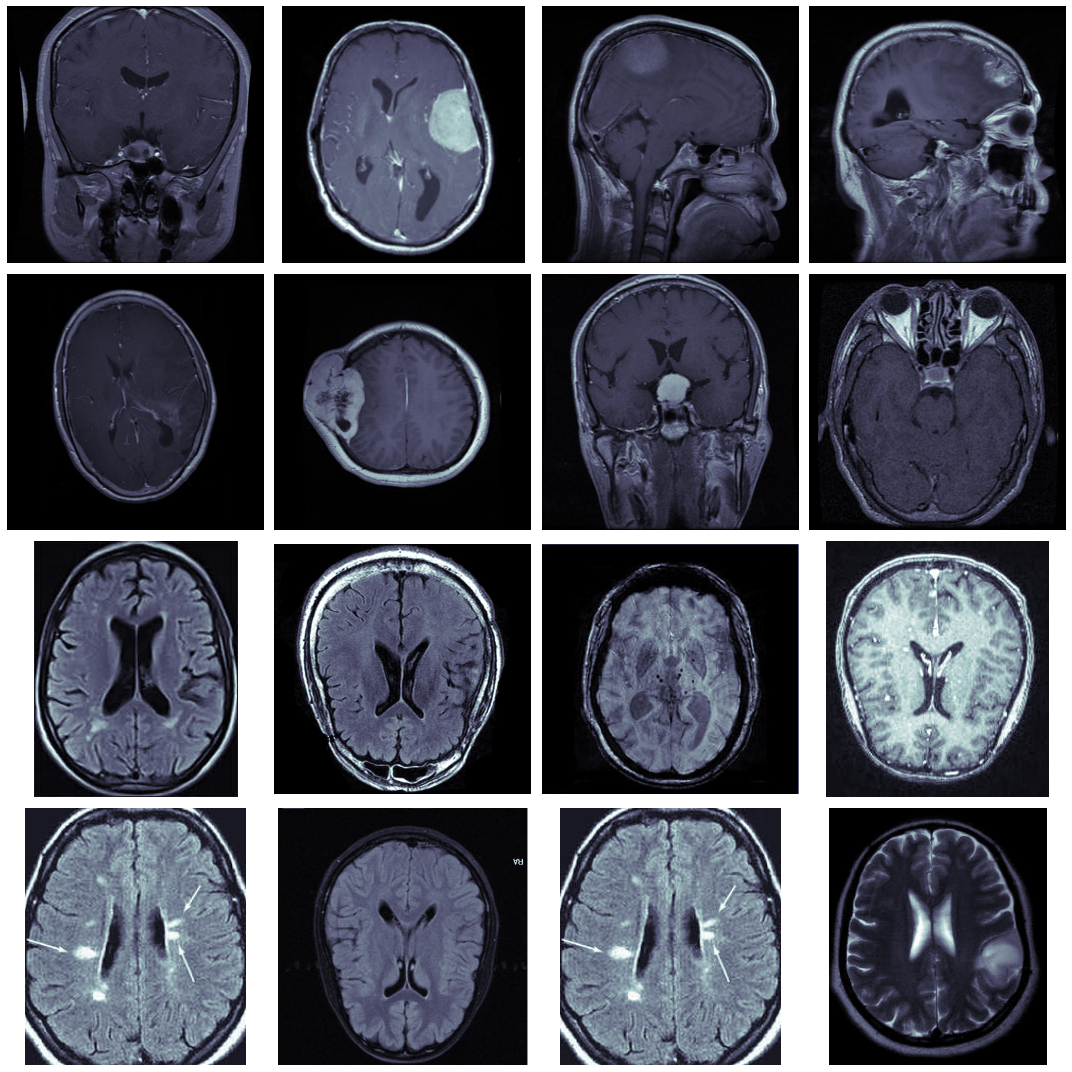

In [88]:
c_idx = 0
r_idx = 0
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for i in range(16):
    file_name = None
    if i < 8:
        # Then load positive image
        file_name = join(special_pos_dir, special_pos_imgs[np.random.randint(0, len(special_pos_imgs))])
    else:
        file_name = join(special_neg_dir, special_neg_imgs[np.random.randint(0, len(special_neg_imgs))])
    
    tmp_img = ImageOps.grayscale(Image.open(file_name, mode='r'))
    axes[r_idx, c_idx].imshow(tmp_img, cmap="bone")
    axes[r_idx, c_idx].axis("off")
    
    if c_idx == 3:
        c_idx = 0
        r_idx += 1
    else:
        c_idx += 1
fig.tight_layout()
plt.show()

## 7.2 Evaluate our first model

The first model we built, a convolusion network with batch normaliztion, performs reasonable well, with an accuracy of 0.7907 and a macro F1 of 0.799. However, this is quite a bit worse than this model scored with the test data from the previous data sets, with which it scored an accuracy of 0.93 and a macro F1 of 0.9344.

In [ ]:
model_own.evaluate(totally_new_test)

## 7.3 Evaluate our Second Model

The second model we built, a residual network, did not do so well with this new image data, having an accuracy of 0.6116 and a macro F1 of 0.6981. This is much reduced compared to this model's performance with the test data from our previous data sets, with which it scored an accuracy of 0.9400 and a macro F1 of 0.9432.

In [104]:
resnet.evaluate(totally_new_test)

43/43 [==============================] - 7s 163ms/step - loss: 1.9645 - accuracy: 0.4031 - f1: 0.5535


[1.9644782543182373, 0.40310078859329224, 0.5534912943840027]

## 7.4 Evalute our pretrained model

The model we built using transfering learning with the EfficientNetV2B2 pretrained model was very robust in handling this totally new data. It had an accuracy of 0.9527 and a macro F1 of 0.9432, which was a slight increase over the performance with the test data from our previous data sets, with which it scored an accuracy of 0.9233 and a macro F1 of 0.9235.

In [207]:
model.evaluate(totally_new_test)

43/43 [==============================] - 42s 965ms/step - loss: 0.1692 - accuracy: 0.9527 - f1: 0.9432


[0.16922736167907715, 0.9527131915092468, 0.9431725144386292]

## 7.5 Evaluate the pretrained model out of the box

### 7.5.1 Load unaltered pretrained model

Here we restore the original version of EfficientNetV2B2.

In [195]:
# instantiating the model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B2(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='avg',
    include_preprocessing=True
)

# Add top layers
inputs = tf.keras.Input(shape=(256, 256, 1))
x = base_model(inputs, training=False)
x = flatten(x)
x = dense1(x) 
x = dropout4(x)
outputs = prediction_layer(x)
model_pretrained_unaltered = tf.keras.Model(inputs, outputs)

# compile the model
model_pretrained_unaltered.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy', f1])

model_pretrained_unaltered.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 efficientnetv2-b2 (Function  (None, 1408)             8769374   
 al)                                                             
                                                                 
 flatten_11 (Flatten)        (None, 1408)              0         
                                                                 
 dense_32 (Dense)            (None, 128)               180352    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 1)                 129       
                                                           

### 7.5.2 Evaluate unaltered pretrained model

Testing the pretrained EfficientNetV2B2 model out of the box, without having done training to tailor the model to predict for brain scan images, it still does alright in predicting whether this totally new batch of brain scans contain or do not contain tumors. The model has an accuracy of 0.8775 and a macro F1 of 0.8631. However, this is worse than the tailored model we created that used this model as its base, which scored an accuracy of 0.9527 and a macro F1 of 0.9432 on this new data.

In [208]:
model_pretrained_unaltered.evaluate(totally_new_test)

43/43 [==============================] - 42s 967ms/step - loss: 0.3070 - accuracy: 0.8775 - f1: 0.8631


[0.3070008456707001, 0.8775193691253662, 0.8630680441856384]

# 8. Conclusion

Comparing two of our own models against a model using transfer learning from a pretrained model shows the value of using transfer learning. Our own models were not as robust on novel data as the model built using tranfer learning, even though our models did as good on the original data sets test data as the pretrained model. It also highlights the importance of using good transfer learning practices to tailor the pretrained model to one's own data. Without doing so, the unaltered pretrained model was about eight percentage points worse than the tailored model. 

The difference in robustness between our models and the tailored pretrained model is most likely do to the number of images the pretrained model was trained on compared to our own models. EfficentNetV2B2 was trained on ImageNet data, which has 14 million images. We trained our models on 2400 images. The key thing to realize is that, even if one creates a model with an excellent structure, making the model robust still requires extensive training, which takes time and is expensive. One can get a high level of quality and robustness through transfer learning quickly and cheaply.